In [ ]:
!nvidia-smi

Mon Jan 31 07:37:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup and Config

In [ ]:
# Requirements
!pip install nltk
!pip install transformers
!pip install shutup
!pip install pytorch-lightning
!pip install torchMetrics

     |████████████████████████████████| 3.5 MB 4.0 MB/s 
     |████████████████████████████████| 895 kB 72.4 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 596 kB 78.1 MB/s 
     |████████████████████████████████| 6.8 MB 84.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 527 kB 4.1 MB/s 
     |████████████████████████████████| 829 kB 82.2 MB/s 
     |████████████████████████████████| 133 kB 70.2 MB/s 
     |████████████████████████████████| 952 kB 67.6 MB/s 
     |████████████████████████████████| 396 kB 72.6 MB/s 
     |████████████████████████████████| 1.1 MB 58.8 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 271 kB 101.1 MB/s 
     |████████████████████████████████| 144 kB 92.2 MB/s 
  Created wheel for future: filename=future-

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import pytorch_lightning as pl
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader, random_split
from pylab import rcParams
from tqdm.auto import tqdm
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torchmetrics.functional import f1, accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from matplotlib import rc

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Text

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('/content/MAMI/TRAINING/training.csv', sep='\t')

In [ ]:
# df_train, df_val = train_test_split(df, test_size=0.15)

In [ ]:
df.rename(columns={'Text Transcription':'text'}, inplace=True)

In [ ]:
df

,file_name,misogynous,shaming,stereotype,objectification,violence,text
0,1.jpg,0,0,0,0,0,Milk Milk.zip
1,10.jpg,1,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,1000.jpg,0,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,0,0,0,0,0,MAN SEEKING WOMAN Ignad 18 O
4,10006.jpg,0,0,0,0,0,Me explaining the deep lore of. J.R.R. Tolkein...
...,...,...,...,...,...,...,...
9995,15002.jpg,0,0,0,0,0,WAITING FOR THE END OF THE COVID imgflip.com
9996,15003.jpg,0,0,0,0,0,SMART WOMEN ARE AROUND imgflip.com
9997,15004.jpg,0,0,0,0,0,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com
9998,15005.jpg,0,0,0,0,0,COOKING FOR MY WIFE imgflip.com


In [ ]:
from nltk import word_tokenize

def preprocess_text(text):

  # Remove extra whitespaces
  text = text.strip()

  # Remove twitter usernames, web addresses
  text = text = re.sub(r"#[\w\d]*|@[.]?[\w\d]*[\'\w*]*|https?:\/\/\S+\b|"r"www\.(\w+\.)+\S*|", '', text)

  # Remove html tags
  text = re.sub(re.compile('<.*?>'), ' ', text)

  # Remove unwanted characters
  text = word_tokenize(text)
  text = ' '.join(word for word in text if word.isalpha() or word.isnumeric() or word.isalnum())
  
  return text

In [ ]:
df.text = np.array([preprocess_text(text) for text in df.text])

In [ ]:
df.text[0]

'Milk'

misogynous         5000
shaming            1274
stereotype         2810
objectification    2202
violence            953
dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


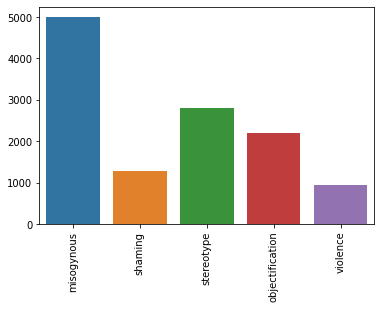

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

y = df[df.columns[1:-1]].sum()
print(y)
bar_plot = sns.barplot(['misogynous','shaming','stereotype','objectification','violence'], y)
plt.setp(bar_plot.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
print(np.array(df[df.columns[2:-1]]).shape)

(10000, 4)


In [ ]:
# token_lens = []

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# def calculate_seq_length(df):
#   for txt in df.text:
#     tokens = tokenizer.encode(str(txt))
#     token_lens.append(len(tokens))

# calculate_seq_length(df)

# sns.histplot(token_lens)
# plt.xlabel('Sequence Length')

In [ ]:
MAX_LEN = 64

In [ ]:
# LABEL_COLUMNS = df.columns.tolist()[1:-1]
# LABEL_COLUMNS

# VisualBERT

visual embedding generated using detectron2

In [ ]:
!gdown --id 1mhT-osDT15obu8FVsgfDAoDd82IY-XQB # visual_embeds_mami.pkl

Downloading...
From: https://drive.google.com/uc?id=1mhT-osDT15obu8FVsgfDAoDd82IY-XQB
To: /content/visual_embeds_mami.pkl
100% 4.10G/4.10G [00:52<00:00, 77.8MB/s]


In [ ]:
!gdown --id 1-015uGUEvocxUWvG7h0Lw61kDUs6xk64 # visual_embeds_test.pkl

Downloading...
From: https://drive.google.com/uc?id=1-015uGUEvocxUWvG7h0Lw61kDUs6xk64
To: /content/visual_embeds_test.pkl
100% 410M/410M [00:06<00:00, 64.8MB/s]


In [ ]:
with open('visual_embeds_mami.pkl', 'rb') as f:
  visual_embeds_mami = pickle.load(f)

In [ ]:
print(len(visual_embeds_mami))
visual_embeds_mami[0].shape

10000


torch.Size([100, 1024])

In [ ]:
from transformers import VisualBertModel, VisualBertConfig

configuration = VisualBertConfig.from_pretrained('uclanlp/visualbert-vqa', visual_embedding_dim=1024)
model = VisualBertModel(configuration)
model = model.to(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/149k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Batch Example

In [ ]:
visual_embeds_mami[:1]
index = 2

In [ ]:
# tokens = tokenizer(df_train.text[index], padding='max_length', max_length=64)

tokens = tokenizer.encode_plus(
      df.text[index],
      add_special_tokens=True,
      max_length=64,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
)

input_ids = torch.tensor(tokens["input_ids"]).to(device).flatten()
attention_mask = torch.tensor(tokens["attention_mask"]).to(device).flatten()

visual_embeds = visual_embeds_mami[index].to(device)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


In [ ]:
print(input_ids.shape)
print(attention_mask.shape)
print(visual_embeds.shape)
print(visual_attention_mask.shape)

torch.Size([64])
torch.Size([64])
torch.Size([100, 1024])
torch.Size([100])


In [ ]:
outputs = model(input_ids=input_ids.unsqueeze(0),
                attention_mask=attention_mask.unsqueeze(0),
                visual_embeds=visual_embeds.unsqueeze(0),
                visual_attention_mask=visual_attention_mask.unsqueeze(0),
                )

# last_hidden_state = outputs.last_hidden_state
print(outputs.last_hidden_state.shape)
print(outputs.pooler_output.shape)

torch.Size([1, 164, 768])
torch.Size([1, 768])


# Dataset
We’ll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

In [ ]:
# LABEL_COLUMNS = df.columns.tolist()[1:-1]
# LABEL_COLUMNS

In [ ]:
for i in range(len(visual_embeds_mami)):
  visual_embeds_mami[i] = visual_embeds_mami[i].to('cpu')

In [ ]:
class MAMIDataset(Dataset):

  def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_len: int, visual_embeds):
    self.tokenizer = tokenizer
    self.data = data
    self.max_len = max_len
    self.visual_embeds = visual_embeds
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):

    data_row = self.data.iloc[index]
    text = data_row.text
    labels = data_row.misogynous

    tokens = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    input_ids = torch.tensor(tokens["input_ids"]).flatten()
    attention_mask = torch.tensor(tokens["attention_mask"]).flatten()

    visual_embedding = self.visual_embeds[index].to('cpu')
    visual_attention_mask = torch.ones(visual_embedding.shape[:-1], dtype=torch.float)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    return dict(
      input_ids=input_ids,
      attention_mask=attention_mask,
      visual_embedding=visual_embedding,
      visual_attention_mask=visual_attention_mask,
      visual_token_type_ids=visual_token_type_ids,
      labels=torch.tensor(labels).float()
    )

In [ ]:
dataset = MAMIDataset(
  df,
  tokenizer,
  MAX_LEN,
  visual_embeds_mami
)

In [ ]:
train_dataset, val_dataset = train_test_split(dataset, test_size=0.10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
train_dataset[7]['labels']

tensor(1.)

In [ ]:
temp = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle=True,
    num_workers=2
    )

In [ ]:
batch_sample = next(iter(temp))

In [ ]:
batch_sample['input_ids'][0]

tensor([  101,  8307,  2655,  1996, 29525,  2023,  4937,  2003,  5305,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])

In [ ]:
batch_sample['labels'].reshape(32, 1)

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]])

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

9000
1000


### Sample Batch

In [ ]:
sample_batch = next(iter(DataLoader(val_dataset, batch_size=8, num_workers=4)))
sample_batch["visual_embedding"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 100, 1024]), torch.Size([8, 64]))

In [ ]:
output = model(input_ids=sample_batch["input_ids"].to(device),
               attention_mask=sample_batch["attention_mask"].to(device),
               visual_embeds=sample_batch['visual_embedding'].to(device),
               visual_attention_mask=sample_batch['visual_attention_mask'].to(device)
               )

# print(output.last_hidden_state.shape, output.pooler_output.shape)

model.config.hidden_size

768

# Data Module

In [ ]:
class MemotionDataModule(pl.LightningDataModule):

  def __init__(self, train_dataset, val_dataset, tokenizer, batch_size=32, max_len=64):
    super().__init__()
    self.batch_size = batch_size
    # self.df = df
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.tokenizer = tokenizer
    self.max_len = max_len
    # self.visual_embeds_mami = visual_embeds_mami
  
  # def setup(self, stage=None):
  #   self.dataset = MAMIDataset(self.df, self.tokenizer, self.max_len, self.visual_embeds_mami)
  #   self.train_dataset, self.val_dataset = train_test_split(self.dataset, test_size=0.1)
  
  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size = self.batch_size,
        shuffle=True,
        num_workers=3
    )
  
  def val_dataloader(self):
    return DataLoader(
        self.val_dataset,
        batch_size = self.batch_size,
        num_workers=3
    )
  
  def test_dataloader(self):
    return DataLoader(
        self.val_dataset,
        batch_size = self.batch_size,
        num_workers=3
    )

In [ ]:
# data_module = MemotionDataModule(
#   df,
#   tokenizer,
#   visual_embeds_mami,
#   BATCH_SIZE,
#   MAX_LEN
# )

# Model

In [ ]:
class MemesClassifier(pl.LightningModule):
  
  def __init__(self, n_classes, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.configuration = VisualBertConfig.from_pretrained('uclanlp/visualbert-vqa-coco-pre', visual_embedding_dim=1024)
    self.model = VisualBertModel(configuration)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.CrossEntropyLoss()
    self.dropout = nn.Dropout(0.2)
    self.classifier = nn.Linear(self.model.config.hidden_size, n_classes)
  
  
  def forward(self, input_ids, attention_mask, visual_embeds, visual_attention_mask, visual_token_type_ids, labels=None):
    output = self.model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        visual_embeds=visual_embeds,
                        visual_attention_mask=visual_attention_mask,
                        visual_token_type_ids=visual_token_type_ids)
    
    # output = self.dropout(output.pooler_output)
    output = self.classifier(output.pooler_output)

    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)

    return loss, output
  
  def training_step(self, batch, batch_idx):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    visual_embeds = batch['visual_embedding'].to(device)
    visual_attention_mask = batch['visual_attention_mask'].to(device)
    visual_token_type_ids = batch['visual_token_type_ids'].to(device)

    labels = batch['labels'].type(torch.LongTensor).to(device)
    
    loss, outputs = self(input_ids, attention_mask, visual_embeds, visual_attention_mask, visual_token_type_ids, labels)
    self.log('train_loss', loss, prog_bar=True, logger=True)

    return {"loss":loss, 'predictions':outputs, 'labels':labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    visual_embeds = batch['visual_embedding']
    visual_attention_mask = batch['visual_attention_mask']
    visual_token_type_ids = batch['visual_token_type_ids'].to(device)
    labels = batch['labels'].type(torch.LongTensor).to(device)
    
    loss, outputs = self(input_ids, attention_mask, visual_embeds, visual_attention_mask, visual_token_type_ids, labels)
    self.log('val_loss', loss, prog_bar=True, logger=True)

    return loss
  
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=3e-5)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=self.n_warmup_steps,
        num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
        )
    )

In [ ]:
n_classes = 2
N_EPOCHS = 2
BATCH_SIZE = 40

In [ ]:
steps_per_epoch = 8000 // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 10
warmup_steps, total_training_steps

(40, 400)

In [ ]:
model = MemesClassifier(
  n_classes=n_classes,
  n_training_steps=total_training_steps,
  n_warmup_steps=0,
).to(device)

# Training

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min",
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="memes-text")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
len(dataset)

10000

In [ ]:
from sklearn.model_selection import KFold
import sklearn



dataset = MAMIDataset(
  df,
  tokenizer,
  MAX_LEN,
  visual_embeds_mami
)

train_dataset, val_dataset = train_test_split(dataset, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

data_module = MemotionDataModule(
    train_dataset=val_dataset,
    val_dataset=val_dataset,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
)

trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=10,
    gpus=1,
    progress_bar_refresh_rate=10
)

trainer.fit(model, data_module)

# n = 5
# kf = KFold(n_splits=n, random_state=RANDOM_SEED, shuffle=True)

# dataset = np.array(dataset)

# for train_index, val_index in kf.split(dataset):
#   train_dataset = dataset[train_index]
#   val_dataset = dataset[val_index]

#   data_module = MemotionDataModule(
#     train_dataset=train_dataset,
#     val_dataset=val_dataset,
#     tokenizer=tokenizer,
#     batch_size=BATCH_SIZE,
#     max_len=MAX_LEN
#   )

#   trainer = pl.Trainer(
#     logger=logger,
#     callbacks=[early_stopping_callback, checkpoint_callback],
#     max_epochs=N_EPOCHS,
#     gpus=1,
#     progress_bar_refresh_rate=10
#   )

#   trainer.fit(model, data_module)

# Evaluation

In [ ]:
trained_model = MemesClassifier.load_from_checkpoint(
  '/content/checkpoints/best-checkpoint-v2.ckpt',
  n_classes=2
)
trained_model.eval()
trained_model.freeze()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

predictions = []
labels = []
for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device),
    item["visual_embedding"].unsqueeze(dim=0).to(device),
    item['visual_attention_mask'].unsqueeze(dim=0).to(device),
    item['visual_token_type_ids'].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
  
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
from torch.nn.functional import softmax

_, preds = torch.max(torch.tensor(predictions), dim=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
preds[17]

tensor(1)

In [ ]:
from sklearn.metrics import f1_score

print("F1 macro:   {}".format(round(f1_score(labels, preds , average="macro"), 3)))
print("F1 micro:   {}".format(round(f1_score(labels, preds > 0.5, average="micro"), 3)))

F1 macro:   0.908
F1 micro:   0.908


In [ ]:
accuracy(predictions, labels)

tensor(0.9080)